## Characterizing geometries of a fracture network (density)

### Import packages

In [1]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Fracture density P21 estimation from fracture interpretation 
Calculating the fracture density from a 2D fracture interpretation. Check Dershowitz and Herda (1992): "Interpretation of fracture spacing & intensity". It requires a grid.

In [2]:
# Load the shapefile of multilines
all = gpd.read_file('data/shapefile/tsan_fractures.shp')
NS = gpd.read_file('data/shapefile/NS.shp')
NESW = gpd.read_file('data/shapefile/NESW.shp')
EW = gpd.read_file('data/shapefile/EW.shp')
NWSE = gpd.read_file('data/shapefile/NWSE.shp')

In [3]:
def frac_density(fractures):
    # Calculate the bounding box of the lines
    minx, miny, maxx, maxy = fractures.total_bounds

    # Define grid size
    num_cells_x = 40
    num_cells_y = 20
    cell_size_x = (maxx - minx) / num_cells_x
    cell_size_y = (maxy - miny) / num_cells_y

    # Create grid
    grid_cells = []
    for i in range(num_cells_x):
        for j in range(num_cells_y):
            x_min = minx + i * cell_size_x
            y_min = miny + j * cell_size_y
            x_max = x_min + cell_size_x
            y_max = y_min + cell_size_y
            grid_cells.append(box(x_min, y_min, x_max, y_max))

    grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=fractures.crs)

    # Compute line lengths
    fractures = fractures.to_crs(grid_gdf.crs)
    grid_gdf['line_length'] = 0.0
    for idx, grid_cell in grid_gdf.iterrows():
        cell_geometry = grid_cell['geometry']
        lines_in_cell = fractures[fractures.intersects(cell_geometry)]
        grid_gdf.at[idx, 'line_length'] = lines_in_cell.geometry.length.sum()

    # Line density = total length / area
    grid_gdf['area'] = cell_size_x * cell_size_y
    grid_gdf['line_density'] = grid_gdf['line_length'] / grid_gdf['area']

    mean_density = round(grid_gdf['line_density'].mean(), 3)

    return mean_density, grid_gdf

In [4]:
P21_all, grid_all = frac_density (all)
P21_NS, grid_NS = frac_density (NS)
P21_NESW, grid_NESW = frac_density (NESW)
P21_EW, grid_EW = frac_density (EW)
P21_NWSE, grid_NWSE = frac_density (NWSE)
print (f'Fracture density, all fractures: {P21_all}, by set NS:{P21_NS}, NESW:{P21_NESW}, EW:{P21_EW}, NWSE:{P21_NWSE}')

Fracture density, all fractures: 0.051, by set NS:0.006, NESW:0.024, EW:0.016, NWSE:0.006


In [5]:
def plot_line_density(fractures, grid_gdf, title='Grid and fracture density (P21)'):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot lines
    fractures.plot(ax=ax, color='blue', alpha=0.5)

    # Normalize color range
    norm = mcolors.Normalize(vmin=grid_gdf['line_density'].min(), vmax=grid_gdf['line_density'].max())
    cmap = plt.cm.Reds

    # Plot grid with colormap
    grid_gdf.plot(
        ax=ax,
        column='line_density',
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        legend=False
    )

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for colorbar
    plt.colorbar(sm, ax=ax, label='Line Density (length/unit area)', fraction=0.02, pad=0.02)

    # Customize plot
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

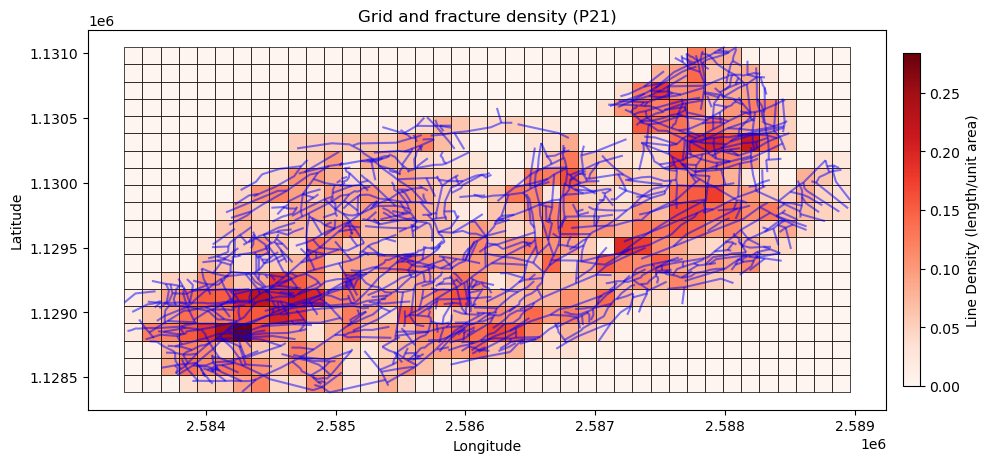

In [6]:
plot_line_density(all, grid_all)

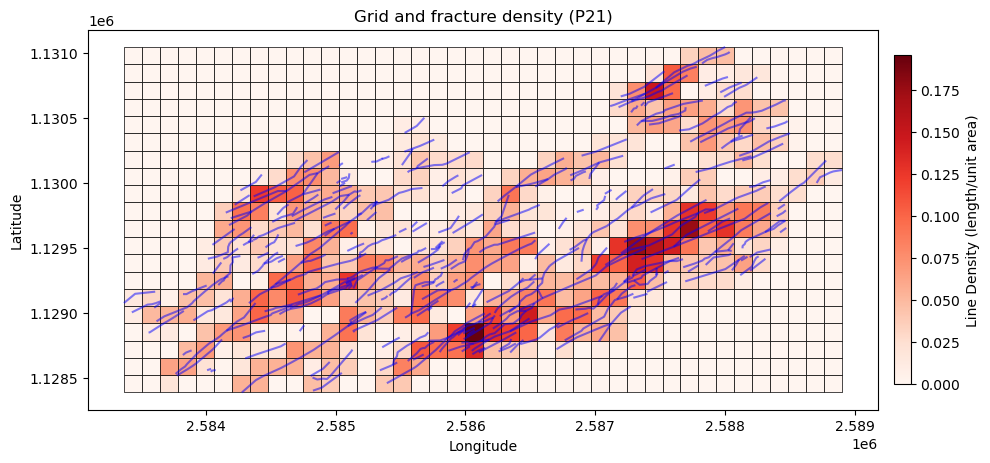

In [7]:
plot_line_density(NESW, grid_NESW)